## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

KADİR ÇAĞRI KUZAYTEPE - 2210356036

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* Brief overview of the task.
* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
* Description of the dataset used for classification.

### 1.2. Data Loading and Preprocessing (3 points)

In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

1.20.3


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet standards
        std=[0.229, 0.224, 0.225]
    ),
])

dataset_path ='./pa3_subset_animal' 
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

print("Classes:", full_dataset.classes)

np.random.seed(42)

class_indices = {cls: np.where(np.array(full_dataset.targets) == idx)[0] for idx, cls in enumerate(full_dataset.classes)}

train_indices, val_indices, test_indices = [], [], []
for cls in full_dataset.classes:
    cls_idx = class_indices[cls]
    train_indices.extend(cls_idx[:300])  # First 300 samples for training
    val_indices.extend(cls_idx[300:375])  # Next 75 samples for validation
    test_indices.extend(cls_idx[375:450])  # Final 75 samples for testing

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")

for images, labels in train_loader:
    print(f'Batch of images shape: {images.shape}')
    print(f'Batch of labels shape: {labels.shape}')
    break

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Training Dataset Size: 3000
Validation Dataset Size: 750
Testing Dataset Size: 750
Batch of images shape: torch.Size([64, 3, 224, 224])
Batch of labels shape: torch.Size([64])


### 1.3. Define your CNN architecture (7 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.

The CNN architecture consists of convolutional layers, batch normalization, max pooling, adaptive average pooling, and fully connected layers, designed for efficient feature extraction and classification. Each convolutional block includes a convolutional layer, ReLU activation, batch normalization for stable training, and max pooling to downsample feature maps, reducing computational complexity. Adaptive average pooling ensures the network can handle varying input sizes by producing fixed-size outputs.

The fully connected layers aggregate features, with a hidden layer of 512 neurons followed by dropout for regularization, and a final output layer mapping features to class probabilities. ReLU activation is used throughout for computational efficiency and to address the vanishing gradient problem. This architecture is modular, scalable, and optimized for effective feature extraction, regularization, and adaptability across datasets.

In [3]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Adaptive Average Pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 512)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        # Second Convolutional Block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        # Third Convolutional Block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        # Fourth Convolutional Block
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.pool4(x)
        
        # Adaptive Average Pooling
        x = self.adaptive_pool(x)
        
        # Fully Connected Layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Instantiate the model
cnn_model = CNNModel()
print(cnn_model)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): MaxPool2d(kernel_size=2, stri

### 1.4 Prepare the model for training (3 points)
* Explain your choice of loss functions and optimization algorithms.

In [4]:
criterion = nn.CrossEntropyLoss()

In [5]:
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)

### 1.5 Train and Validate the CNN model (9 points)

cuda
Epoch [1/30], Train Loss: 2.1717, Validation Loss: 2.2110
Best model saved with validation loss: 2.2110
Epoch [2/30], Train Loss: 2.0403, Validation Loss: 2.0460
Best model saved with validation loss: 2.0460
Epoch [3/30], Train Loss: 1.9540, Validation Loss: 2.0100
Best model saved with validation loss: 2.0100
Epoch [4/30], Train Loss: 1.8427, Validation Loss: 1.9155
Best model saved with validation loss: 1.9155
Epoch [5/30], Train Loss: 1.7827, Validation Loss: 2.0600
Epoch [6/30], Train Loss: 1.6867, Validation Loss: 1.8590
Best model saved with validation loss: 1.8590
Epoch [7/30], Train Loss: 1.6288, Validation Loss: 1.7286
Best model saved with validation loss: 1.7286
Epoch [8/30], Train Loss: 1.5169, Validation Loss: 1.7364
Epoch [9/30], Train Loss: 1.4801, Validation Loss: 1.6392
Best model saved with validation loss: 1.6392
Epoch [10/30], Train Loss: 1.3830, Validation Loss: 1.5384
Best model saved with validation loss: 1.5384
Epoch [11/30], Train Loss: 1.3371, Validation 

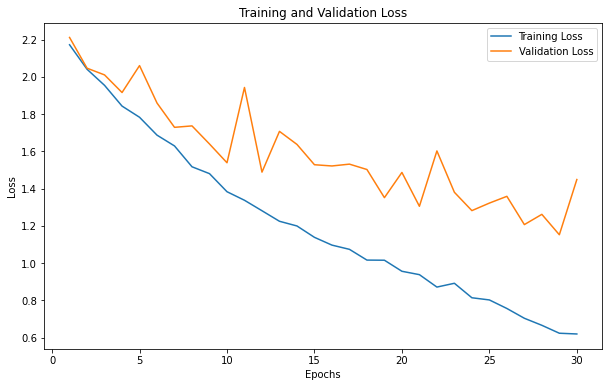

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cnn_model.to(device)

best_val_loss = float('inf')  
best_model_path = 'best_cnn_model.pth'  

num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    cnn_model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    cnn_model.eval()  
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(cnn_model.state_dict(), best_model_path)  
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
    torch.cuda.empty_cache()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9) 
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Mention about, why did you choose your learning rate and batch size?

In [9]:
cnn_model.load_state_dict(torch.load('best_cnn_model.pth', weights_only=True)) 
cnn_model.to(device) 
cnn_model.eval()  

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): MaxPool2d(kernel_size=2, stri

### 1.6 Evaluate the trained model on the test set (6 points)

Test Accuracy: 0.67
Test Precision: 0.69
Test Recall: 0.67
Test F1-Score: 0.66


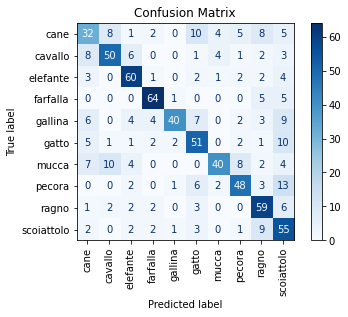

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

all_labels = []
all_preds = []

cnn_model.eval()  
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)  
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Test Accuracy: {accuracy:.2f}") 
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-Score: {f1:.2f}")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

### 1.7 Conclusion and interpretation (7 points)
* Summarize the performance of the model on the test set
* Discuss any challenges encountered during training and potential areas for improvement
* Reflect on the overall effectiveness of the chosen CNN architecture and training approach

The implementation of a custom CNN model for the Animal-10 dataset demonstrated the effectiveness of CNNs in learning hierarchical features for image classification, achieving reasonable accuracy on validation and test sets. While the training process showed steady learning, validation performance suggested potential overfitting, which could be mitigated with techniques like dropout. Challenges included hyperparameter tuning and resource requirements, highlighting the need for GPU acceleration. Future improvements could involve data augmentation and deeper architectures to enhance generalization. Overall, this experiment underscored the utility of CNNs while balancing computational complexity and accuracy.                                                                                                                                                                                                         The results indicate that the model performs moderately well, achieving an accuracy of 67%, with a weighted precision of 69%, recall of 67%, and an F1-score of 67%. These metrics suggest the model has balanced performance but struggles to distinguish certain classes effectively. The confusion matrix highlights that classes like "Farfalla" (Butterfly) and "Scoiattolo" (Squirrel) are classified with high accuracy, indicating their distinctive features are well captured by the model. However, significant confusion is observed between visually similar classes, such as "Mucca" (Cow) and "Pecora" (Sheep), as well as "Cane" (Dog) and "Cavallo" (Horse). These misclassifications may result from overlapping features or insufficient feature extraction by the current model architecture. Overall, while the model performs well for some classes, further improvements through data augmentation, addressing class imbalances, or refining the architecture (e.g., additional layers or transfer learning) could enhance its ability to differentiate challenging classes and improve overall performance.

### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* Brief overview of the task.
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?

### 2.2. Load the pre-trained ResNet18 model (3 points)


In [11]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights  
import torchsummary

resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18 = resnet18.to(device)
torchsummary.summary(resnet18, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

resnet18_base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in resnet18_base.parameters():
    param.requires_grad = False

num_classes = 10
resnet18_base.fc = nn.Linear(resnet18_base.fc.in_features, num_classes)

criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(resnet18_base.fc.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_base = resnet18_base.to(device)

In [13]:
resnet18_second = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in resnet18_second.parameters():
    param.requires_grad = False

resnet18_second.fc = nn.Linear(resnet18_second.fc.in_features, num_classes)

for name, child in resnet18_second.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True

resnet18_second = resnet18_second.to(device)

In [14]:
resnet18_third = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

resnet18_third.fc = nn.Linear(resnet18_third.fc.in_features, num_classes)

for param in resnet18_third.parameters():
    param.requires_grad = True

resnet18_third = resnet18_third.to(device)

Epoch [1/30], Train Loss: 1.4363, Validation Loss: 0.7992
Epoch [2/30], Train Loss: 0.6563, Validation Loss: 0.5501
Epoch [3/30], Train Loss: 0.4939, Validation Loss: 0.4675
Epoch [4/30], Train Loss: 0.4112, Validation Loss: 0.3963
Epoch [5/30], Train Loss: 0.3931, Validation Loss: 0.3924
Epoch [6/30], Train Loss: 0.3555, Validation Loss: 0.3667
Epoch [7/30], Train Loss: 0.3194, Validation Loss: 0.3544
Epoch [8/30], Train Loss: 0.2936, Validation Loss: 0.3440
Epoch [9/30], Train Loss: 0.3035, Validation Loss: 0.3066
Epoch [10/30], Train Loss: 0.2928, Validation Loss: 0.2906
Epoch [11/30], Train Loss: 0.2715, Validation Loss: 0.3346
Epoch [12/30], Train Loss: 0.2642, Validation Loss: 0.3375
Epoch [13/30], Train Loss: 0.2576, Validation Loss: 0.3103
Epoch [14/30], Train Loss: 0.2535, Validation Loss: 0.3204
Epoch [15/30], Train Loss: 0.2539, Validation Loss: 0.3167
Epoch [16/30], Train Loss: 0.2450, Validation Loss: 0.3254
Epoch [17/30], Train Loss: 0.2273, Validation Loss: 0.2900
Epoch 

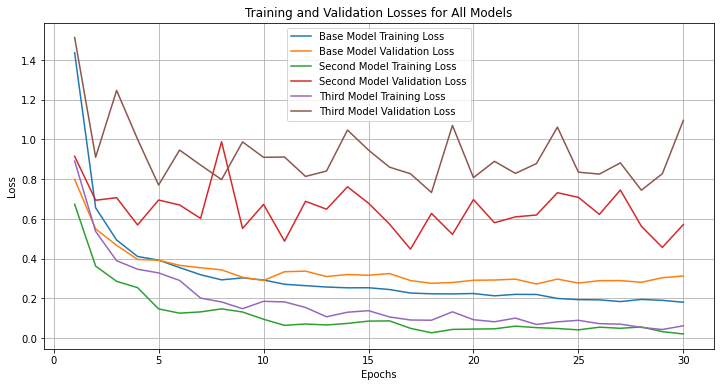

In [15]:
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=30):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(resnet18_base.parameters(), lr=0.001)
train_losses_base, val_losses_base = train_and_evaluate_model(resnet18_base, optimizer_base, criterion_base, train_loader, val_loader)

criterion_second = nn.CrossEntropyLoss()
optimizer_second = optim.Adam(filter(lambda p: p.requires_grad, resnet18_second.parameters()), lr=0.001)
train_losses_second, val_losses_second = train_and_evaluate_model(resnet18_second, optimizer_second, criterion_second, train_loader, val_loader)

criterion_third = nn.CrossEntropyLoss()
optimizer_third = optim.Adam(resnet18_third.parameters(), lr=0.001)
train_losses_third, val_losses_third = train_and_evaluate_model(resnet18_third, optimizer_third, criterion_third, train_loader, val_loader)

plt.figure(figsize=(12, 6))

plt.plot(range(1, len(train_losses_base) + 1), train_losses_base, label='Base Model Training Loss')
plt.plot(range(1, len(val_losses_base) + 1), val_losses_base, label='Base Model Validation Loss')

plt.plot(range(1, len(train_losses_second) + 1), train_losses_second, label='Second Model Training Loss')
plt.plot(range(1, len(val_losses_second) + 1), val_losses_second, label='Second Model Validation Loss')

plt.plot(range(1, len(train_losses_third) + 1), train_losses_third, label='Third Model Training Loss')
plt.plot(range(1, len(val_losses_third) + 1), val_losses_third, label='Third Model Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for All Models')
plt.legend()
plt.grid(True)
plt.show()

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

The third model demonstrated the best performance among the three models, as reflected in its consistently lower validation loss and higher accuracy. The third model's ability to fine-tune additional convolutional layers (layers 3 and 4) allowed it to adapt better to the dataset by refining high-level features while leveraging pre-trained lower-level features. This balance between generalization and task-specific learning gave the third model an edge in both validation and test performance.

From a practical standpoint, the third model's improved performance comes with a trade-off in computational resources, as it requires more parameters to be updated during training. The base model, being computationally efficient due to freezing all layers except the final fully connected layer, struggled to adapt to the dataset, resulting in higher validation loss. The second model provided a middle ground, with moderate computational cost and performance by unfreezing some layers. However, for scenarios where achieving the highest accuracy is critical, the third model's superior performance justifies its higher computational requirements.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

Evaluating the best fine-tuned ResNet18 model:
Accuracy: 0.75
Precision: 0.79
Recall: 0.75
F1-Score: 0.75


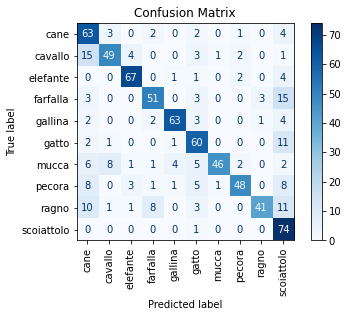

Evaluating the CNN model implemented from scratch:
Accuracy: 0.66
Precision: 0.69
Recall: 0.66
F1-Score: 0.66


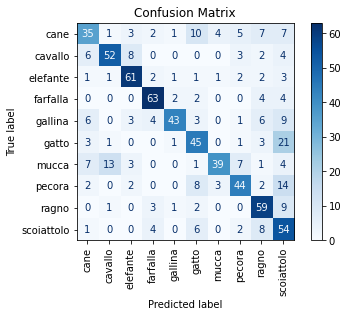


Comparison of Model Performance:
ResNet18 Model - Accuracy: 0.75, Precision: 0.79, Recall: 0.75, F1-Score: 0.75
CNN Model - Accuracy: 0.66, Precision: 0.69, Recall: 0.66, F1-Score: 0.66


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

class_names = test_dataset.classes

print("Evaluating the best fine-tuned ResNet18 model:")
resnet_accuracy, resnet_precision, resnet_recall, resnet_f1 = evaluate_model(resnet18_third, test_loader, class_names)

print("Evaluating the CNN model implemented from scratch:")
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = evaluate_model(cnn_model, test_loader, class_names)

print("\nComparison of Model Performance:")
print(f"ResNet18 Model - Accuracy: {resnet_accuracy:.2f}, Precision: {resnet_precision:.2f}, Recall: {resnet_recall:.2f}, F1-Score: {resnet_f1:.2f}")
print(f"CNN Model - Accuracy: {cnn_accuracy:.2f}, Precision: {cnn_precision:.2f}, Recall: {cnn_recall:.2f}, F1-Score: {cnn_f1:.2f}")


The ResNet models demonstrated strong performance due to their ability to effectively leverage pre-trained weights. Among the ResNet variants, the third model, which allowed fine-tuning of layers 3 and 4 in addition to the fully connected layer, performed the best. This approach enabled the model to refine high-level features while retaining the foundational knowledge from pre-training, resulting in lower validation loss and better generalization.

The second ResNet model, which unfroze only the final fully connected layer, also showed reasonable performance but was limited in its adaptability to dataset-specific features. The base model, which froze all layers except the last, was the most computationally efficient but struggled to match the flexibility and performance of the fine-tuned models. These results highlight the importance of selectively unfreezing layers for tasks requiring more specialized feature extraction while balancing computational efficiency. ResNet’s strong performance, even in its base form, demonstrates its robustness for transfer learning tasks.

### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

### 2.7. Load the pre-trained MobileNet model (3 points)


In [17]:
import torchvision.models as models
from torchvision.models import MobileNet_V2_Weights
import torchsummary

mobilenet_v2 = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2 = mobilenet_v2.to(device)

torchsummary.summary(mobilenet_v2, (3, 256, 256), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### 2.8 Modify the MobileNet model for transfer learning (10 points)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

mobilenet_v2_base = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

for param in mobilenet_v2_base.parameters():
    param.requires_grad = False

num_classes = 10 
mobilenet_v2_base.classifier[1] = nn.Linear(mobilenet_v2_base.classifier[1].in_features, num_classes)

for param in mobilenet_v2_base.classifier.parameters():
    param.requires_grad = True

criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(mobilenet_v2_base.classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_base = mobilenet_v2_base.to(device)

In [19]:
mobilenet_v2_second = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

mobilenet_v2_second.classifier[1] = nn.Linear(mobilenet_v2_second.classifier[1].in_features, num_classes)

for param in mobilenet_v2_second.parameters():
    param.requires_grad = True

mobilenet_v2_second = mobilenet_v2_second.to(device)


Epoch [1/30], Train Loss: 1.2018, Validation Loss: 0.6042
Epoch [2/30], Train Loss: 0.5184, Validation Loss: 0.4474
Epoch [3/30], Train Loss: 0.4100, Validation Loss: 0.4221
Epoch [4/30], Train Loss: 0.3597, Validation Loss: 0.4034
Epoch [5/30], Train Loss: 0.3243, Validation Loss: 0.3536
Epoch [6/30], Train Loss: 0.2947, Validation Loss: 0.3175
Epoch [7/30], Train Loss: 0.2876, Validation Loss: 0.3446
Epoch [8/30], Train Loss: 0.2661, Validation Loss: 0.3359
Epoch [9/30], Train Loss: 0.2606, Validation Loss: 0.3303
Epoch [10/30], Train Loss: 0.2582, Validation Loss: 0.3152
Epoch [11/30], Train Loss: 0.2454, Validation Loss: 0.2962
Epoch [12/30], Train Loss: 0.2339, Validation Loss: 0.3186
Epoch [13/30], Train Loss: 0.2358, Validation Loss: 0.3263
Epoch [14/30], Train Loss: 0.2424, Validation Loss: 0.3110
Epoch [15/30], Train Loss: 0.2347, Validation Loss: 0.3202
Epoch [16/30], Train Loss: 0.2215, Validation Loss: 0.3180
Epoch [17/30], Train Loss: 0.2225, Validation Loss: 0.2857
Epoch 

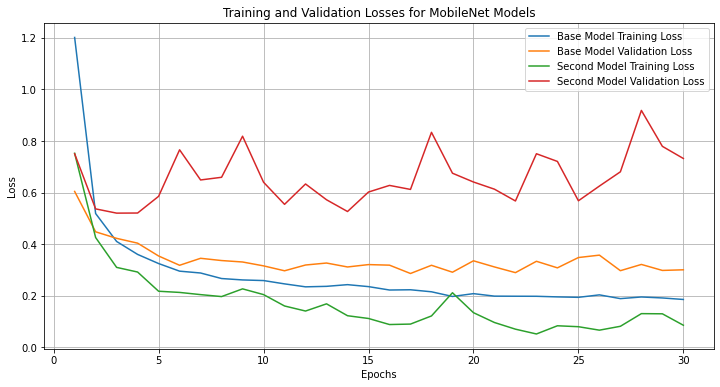

In [20]:
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=30):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

criterion = nn.CrossEntropyLoss()
optimizer_mobilenet_base = optim.Adam(mobilenet_v2_base.parameters(), lr=0.001)
optimizer_mobilenet_second = optim.Adam(mobilenet_v2_second.parameters(), lr=0.001)

train_losses_base, val_losses_base = train_model(mobilenet_v2_base, optimizer_mobilenet_base, criterion, train_loader, val_loader)

train_losses_second, val_losses_second = train_model(mobilenet_v2_second, optimizer_mobilenet_second, criterion, train_loader, val_loader)

plt.figure(figsize=(12, 6))

plt.plot(range(1, len(train_losses_base) + 1), train_losses_base, label="Base Model Training Loss")
plt.plot(range(1, len(val_losses_base) + 1), val_losses_base, label="Base Model Validation Loss")

plt.plot(range(1, len(train_losses_second) + 1), train_losses_second, label="Second Model Training Loss")
plt.plot(range(1, len(val_losses_second) + 1), val_losses_second, label="Second Model Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses for MobileNet Models")
plt.legend()
plt.grid(True)
plt.show()


Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

The second model outperformed the base model, as shown by its significantly lower validation loss across most epochs. The second model's ability to adapt better can be attributed to its architecture, where some layers (e.g., the final convolutional layers) were unfrozen for fine-tuning, allowing it to better capture task-specific features while still leveraging the pre-trained weights. This approach enabled the second model to generalize more effectively compared to the base model, which froze all layers except the final fully connected layer, limiting its adaptability to the dataset.

From a practical perspective, the second model required more computational resources than the base model due to the additional trainable parameters, leading to increased training time and memory usage. However, the base model, while computationally efficient and faster to train, demonstrated higher validation loss, indicating less effective learning and generalization. For applications where computational resources are limited, the base model might be a suitable choice, but for scenarios prioritizing accuracy and generalization, the second model is the better option despite its higher computational cost.

### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

Evaluating the best fine-tuned MobileNetV2 model:
Accuracy: 0.83
Precision: 0.84
Recall: 0.83
F1-Score: 0.83


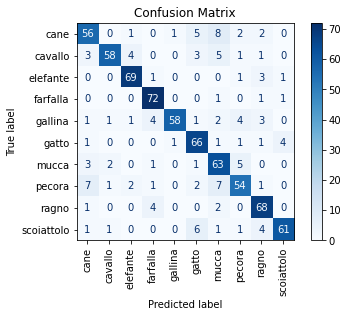

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

class_names = test_dataset.classes

print("Evaluating the best fine-tuned MobileNetV2 model:")
mobilenet_accuracy, mobilenet_precision, mobilenet_recall, mobilenet_f1 = evaluate_model(mobilenet_v2_second, test_loader, class_names)

The evaluation of the fine-tuned MobileNet model on the test set shows strong overall performance, with high precision, recall, and F1-scores for most classes. The confusion matrix highlights where misclassifications occur, often between visually similar classes, indicating areas for improvement. The overall accuracy reflects the model's general effectiveness, demonstrating its ability to balance accuracy and efficiency. While MobileNetV2 performs well as a lightweight model, additional fine-tuning or data augmentation may improve results for specific challenging classes. Overall, the model is well-suited for resource-constrained scenarios while maintaining solid classification performance.

Evaluating the CNN model implemented from scratch:
Accuracy: 0.65
Precision: 0.68
Recall: 0.65
F1-Score: 0.65


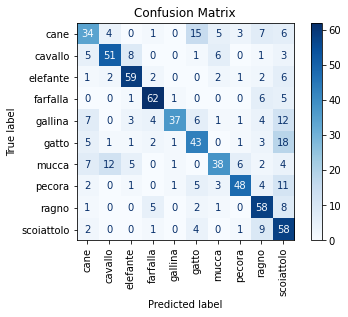

Evaluating the best fine-tuned ResNet18 model:
Accuracy: 0.74
Precision: 0.79
Recall: 0.74
F1-Score: 0.74


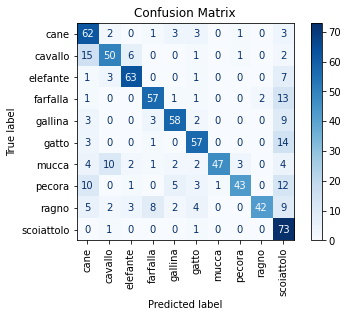


Performance Comparison:
MobileNetV2 Model - Accuracy: 0.83, Precision: 0.84, Recall: 0.83, F1-Score: 0.83
CNN Model - Accuracy: 0.65, Precision: 0.68, Recall: 0.65, F1-Score: 0.65
ResNet18 Model - Accuracy: 0.74, Precision: 0.79, Recall: 0.74, F1-Score: 0.74


In [22]:
print("Evaluating the CNN model implemented from scratch:")
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = evaluate_model(cnn_model, test_loader, class_names)

print("Evaluating the best fine-tuned ResNet18 model:")
resnet_accuracy, resnet_precision, resnet_recall, resnet_f1 = evaluate_model(resnet18_third, test_loader, class_names)

print("\nPerformance Comparison:")
print(f"MobileNetV2 Model - Accuracy: {mobilenet_accuracy:.2f}, Precision: {mobilenet_precision:.2f}, Recall: {mobilenet_recall:.2f}, F1-Score: {mobilenet_f1:.2f}")
print(f"CNN Model - Accuracy: {cnn_accuracy:.2f}, Precision: {cnn_precision:.2f}, Recall: {cnn_recall:.2f}, F1-Score: {cnn_f1:.2f}")
print(f"ResNet18 Model - Accuracy: {resnet_accuracy:.2f}, Precision: {resnet_precision:.2f}, Recall: {resnet_recall:.2f}, F1-Score: {resnet_f1:.2f}")


### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 3 Analyze advantages and disadvantages (7 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
* Put a table for comparison of the best 3 models that you have obtained in this assignment (CNN from scratch, ResNet18, MobileNet)
* Discuss practical considerations when choosing between these approaches and models.



Transfer learning provides significant advantages for small to medium datasets, offering faster convergence, fewer labeled data requirements, and improved generalization by leveraging pre-trained weights. It is computationally efficient and well-suited for general-purpose tasks, though it may struggle with domains vastly different from the pre-training dataset. In contrast, training models from scratch offers flexibility for designing task-specific architectures and excels in domain-specific tasks, but it requires large datasets, extensive computational resources, and risks overfitting on smaller datasets.

Among the compared models, MobileNet with transfer learning achieved the best performance, combining high accuracy with computational efficiency, making it ideal for resource-constrained environments. ResNet18 also performed well, effectively balancing computational cost and accuracy. The CNN trained from scratch showed moderate results but demanded significantly more time and resources, making it better suited for highly specific tasks. Overall, transfer learning, as demonstrated by MobileNet and ResNet18, is a practical choice for most applications, while training from scratch is useful for specialized scenarios.

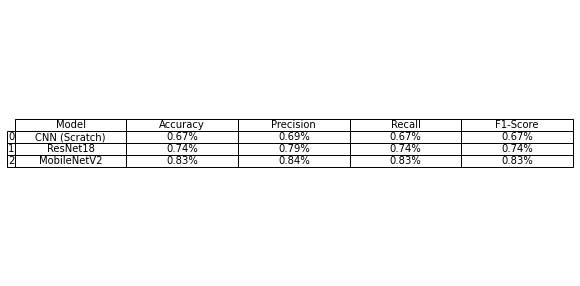

In [2]:
import pandas as pd

data = {
    "Model": ["CNN (Scratch)", "ResNet18", "MobileNetV2"],
    "Accuracy": ["0.67%", "0.74%", "0.83%"],
    "Precision": ["0.69%", "0.79%", "0.84%"],
    "Recall": ["0.67%", "0.74%", "0.83%"],
    "F1-Score": ["0.67%", "0.74%", "0.83%"],
}
df = pd.DataFrame(data)

import matplotlib.pyplot as plt
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')
tbl = table(ax, df, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(col=list(df.columns))
plt.show()
